# Бустинг. Практика

Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection, tree, ensemble, metrics

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./../data/spam7.csv')

In [3]:
df.sample(5)

,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
4157,4158,106,0.000,0.045,0.00,0.00,0.00,n
859,860,1458,0.155,0.326,0.19,0.39,0.09,y
1710,1711,153,0.000,0.000,0.00,0.00,0.00,y
311,312,264,0.000,0.718,0.00,0.00,0.00,y
3693,3694,2051,0.000,0.037,0.00,0.00,0.00,n


Из столбца yesno сделайте столбец spam, где 1 соответствует значению y (является спамом), а 0 – n (не является спамом). Удалите первый столбец (с индексом) и столбец "yesno".

In [4]:
df['spam'] = df['yesno'].apply(lambda x: 1 if x == 'y' else 0)

In [5]:
df.drop(columns=['Unnamed: 0', 'yesno'], inplace=True)

In [6]:
df.sample(5)

,crl.tot,dollar,bang,money,n000,make,spam
4411,59,0.000,0.000,0.0,0.00,0.00,0
2345,3168,0.005,0.002,0.0,0.07,0.03,0
1808,182,0.000,0.000,0.0,0.00,0.00,1
761,101,0.000,0.117,0.0,0.00,0.00,1
4509,164,0.000,0.000,0.0,0.00,0.00,0


У Вас остается шесть столбцов-признаков и один столбец spam, который является нашей целевой переменной. Разделим их на x и у.

In [7]:
X, y = df.drop(columns=['spam']), df['spam']

Комбинации признаков должны иметь вид "признак1_признак2".

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

In [8]:
col_index = 0
columns = X.columns.copy()

for col in columns:
    col_index += 1
    for i in range(col_index, len(columns)):
        X[col + '_' + columns[i]] = X[col] * X[columns[i]]

In [9]:
X.sample(5)

,crl.tot,dollar,bang,money,n000,make,crl.tot_dollar,crl.tot_bang,crl.tot_money,crl.tot_n000,...,dollar_bang,dollar_money,dollar_n000,dollar_make,bang_money,bang_n000,bang_make,money_n000,money_make,n000_make
2777,237,0.000,0.000,0.00,0.00,0.0,0.000,0.000,0.00,0.00,...,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0000,0.0,0.0
2991,274,0.000,0.000,0.00,0.00,0.0,0.000,0.000,0.00,0.00,...,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0000,0.0,0.0
946,277,0.000,0.034,0.00,0.00,0.0,0.000,9.418,0.00,0.00,...,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0000,0.0,0.0
3234,5,0.000,0.000,0.00,0.00,0.0,0.000,0.000,0.00,0.00,...,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0000,0.0,0.0
976,1038,0.107,0.134,0.81,0.16,0.0,111.066,139.092,840.78,166.08,...,0.014338,0.08667,0.01712,0.0,0.10854,0.02144,0.0,0.1296,0.0,0.0


In [10]:
RANDOM_STATE = 42

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [12]:
boost_clf = ensemble.GradientBoostingClassifier(random_state=RANDOM_STATE)
boost_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [13]:
np.round(metrics.accuracy_score(y_test, boost_clf.predict(X_test)), 3)

0.865

Воспользуйтесь методом feature_importances_. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. В ответе укажите третий по важности признак (без кавычек и пробелов).

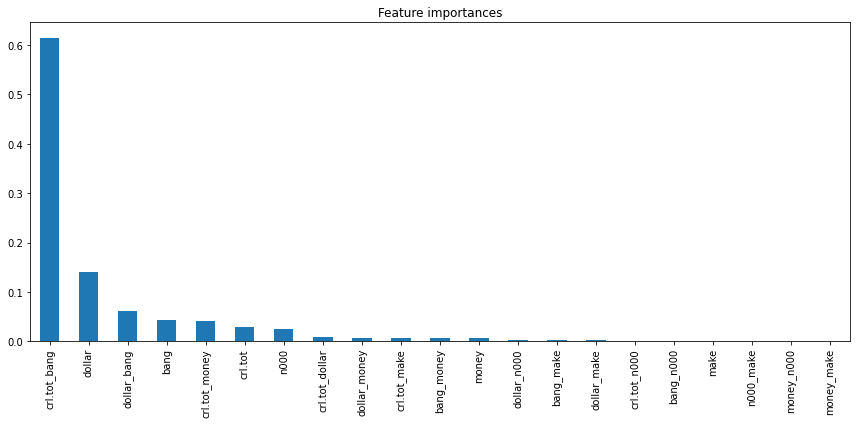

In [14]:
forest_importances = pd.Series(boost_clf.feature_importances_, index=X.columns)

fig, ax = plt.subplots(figsize=(12, 6))

forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

Теперь перейдем к подбору параметров в модели. Для этого в библиотеке scikit-learn есть метод GridSearchCV. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода fit модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве estimator градиетный бустинг с параметрами по дефолту и `random_state=42`. В параметре scoring укажите `'accuracy', n_jobs=-1, cv=5`.

Сетку параметров задайте такой:

In [15]:
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]
}

In [16]:
gr_search = model_selection.GridSearchCV(
    boost_clf,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5
)

In [17]:
gr_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500,
                                          1750]},
             scoring='accuracy')

In [22]:
np.round(gr_search.best_score_, 3)

0.884

Подбор параметров — незаменимый инструмент при настройке моделей. Однако, если данных очень много, а модель сложная, то иногда имеет смысл ограничить количество параметров, которые вы хотите перебрать. Если модель с одним набором параметров обучается 30 минут, а вы хотите перебрать 10 таких наборов, то стоит приготовиться к пятичасовому ожиданию. Также стоит учитывать, что размер некоторых параметров влияет на время, потраченное на обучение моделей. Например, менее глубокие деревья учатся быстрее, чем глубокие.

При использовании GridSearchCV перебираются все возможные способы комбинации параметров.

Теперь воспользуемся GridSearchCV для подбора максимальной глубины (max_depth). В качестве estimator используйте градиентный бустинг с раннеее подобранными параметрами и random_state=42. Переберите все значения max_depth от 5 до 15 включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [39]:
param_grid['max_depth'] = [i for i in range(5, 16)]

In [41]:
gr_search = model_selection.GridSearchCV(
    boost_clf,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5
)

In [ ]:
gr_search.fit(X_train, y_train)

In [ ]:
np.round(gr_search.best_score_, 3)